In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

***UNDUH DAN EKSTRAKSI DATASET***

In [ ]:
import zipfile,os

!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
 -O /tmp/rockpaperscissors.zip

# melakukan ekstraksi pada file zip
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-07-08 22:39:44--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  8.72MB/s    in 71s     

2020-07-08 22:40:57 (4.32 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



***PEMROSESAN DATA (PRE-PROCESSING, AUGMENTASI GAMBAR)***

In [ ]:
folder_path = '/tmp/rockpaperscissors/rps-cv-images'

train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip = True,
                    validation_split=0.2, #langsung dipisah dari gambar yg ada terkait data train & data validationnya
                    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        folder_path,
        target_size=(224,224),  # ganti resolusi
        batch_size=32,
        subset='training', 
        class_mode='categorical',
        shuffle=True, 
        )  
  
validation_generator = train_datagen.flow_from_directory(
        folder_path,
        target_size=(224,224), # ganti resolusi
        batch_size=32,
        subset='validation',
        class_mode='categorical',
        shuffle=False, #mengurutkan data dalam urutan alfanumerik
        )

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


***MEMBANGUN ARSITEKTUR CNN***

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

best_model_weights = './base.model'
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(best_model_weights,
      monitor='val_loss',
      verbose=1,
      save_best_only=True,
      mode='min',
      save_weights_only=False,
      save_freq='epoch'
      #period=10
    ),

    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
      min_delta=0.001,
      patience=10,
      verbose=1,
      mode='auto'
    ),

    tf.keras.callbacks.TensorBoard(log_dir = './logs',
      histogram_freq=0,
      batch_size=16,
      write_graph=True,
      write_grads=True,
      write_images=False
    ),

    tf.keras.callbacks.CSVLogger(
        filename= "training_csv.log",
        separator = ",",
        append = False
    ),

    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
      factor=0.5,
      patience=40,
      verbose=1, 
      mode='auto',
      cooldown=1
    )
]


#memanggil fungsi compile pada objek model, dan tentukan loss function serta optimizer.
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', #tf.optimizers.Adam()
              metrics=['accuracy'])


history =  model.fit(
      train_generator,
      steps_per_epoch=1751/32 ,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=10,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=437/32,  # berapa batch yang akan dieksekusi pada setiap epoch
      callbacks=callbacks,
      verbose=1)

Epoch 1/10
55/54 [==============================] - ETA: 0s - loss: 1.1298 - accuracy: 0.3758
Epoch 00001: val_loss improved from inf to 1.06175, saving model to ./base.model
INFO:tensorflow:Assets written to: ./base.model/assets
55/54 [==============================] - 155s 3s/step - loss: 1.1298 - accuracy: 0.3758 - val_loss: 1.0618 - val_accuracy: 0.4371 - lr: 0.0010
Epoch 2/10
55/54 [==============================] - ETA: 0s - loss: 0.9467 - accuracy: 0.5682
Epoch 00002: val_loss improved from 1.06175 to 0.75591, saving model to ./base.model
INFO:tensorflow:Assets written to: ./base.model/assets
55/54 [==============================] - 155s 3s/step - loss: 0.9467 - accuracy: 0.5682 - val_loss: 0.7559 - val_accuracy: 0.7300 - lr: 0.0010
Epoch 3/10
55/54 [==============================] - ETA: 0s - loss: 0.6653 - accuracy: 0.7139
Epoch 00003: val_loss improved from 0.75591 to 0.54535, saving model to ./base.model
INFO:tensorflow:Assets written to: ./base.model/assets
55/54 [=========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


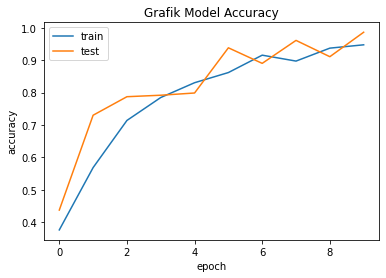

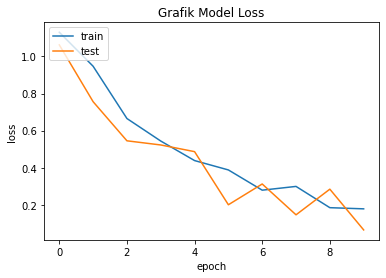

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# tampilkan daftar semua data history
print(history.history.keys())
# menampilkan rangkuman riwayat akurasi model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Grafik Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# menampilkan rangkuman riwayat loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Grafik Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

***TEST UPLOAD***

Saving photo_2020-07-08_17-14-52.jpg to photo_2020-07-08_17-14-52.jpg
[[1. 0. 0.]]
{'paper': 0, 'rock': 1, 'scissors': 2}
Gambar yang diprediksi adalah bentuk kertas


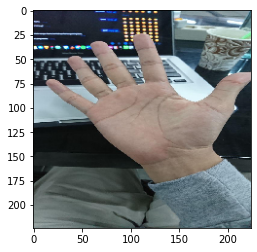

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # memprediksi gambar yang di upload
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  categories = model.predict(images, batch_size=10)
  
  print(categories)
  print(train_generator.class_indices)
  if categories[0][0]==1:
    print('Gambar yang diprediksi adalah bentuk kertas')
  elif categories[0][1]==1:
    print('Gambar yang diprediksi adalah bentuk batu')
  elif categories[0][2]==1:
    print("Gambar yang diprediksi adalah bentuk gunting")

  
